In [116]:
import sys
import os

# add project root directory to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

print("Added path:", project_root)


Added path: c:\Users\lenovo\Desktop\Machine Learning\Employee_Attrition_Predictor


In [117]:
import pandas as pd
from app.database_connector import DatabaseConnector
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
# reading dataset
df = pd.read_csv("../data/raw/HR-Employee-Attrition.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


insert dataset into Mysql employee table

In [119]:
db = DatabaseConnector()

connection = db.connect()
cursor = connection.cursor()

In [120]:
for _, row in df.iterrows():
    sql = """
        INSERT INTO employees
        (age, gender, department, job_role, monthly_income, years_at_company,
         job_satisfaction, performance_rating, overtime, attrition)
        VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
    """
    cursor.execute(sql, (
        row['Age'], row['Gender'], row['Department'], row['JobRole'],
        row['MonthlyIncome'], row['YearsAtCompany'], row['JobSatisfaction'],
        row['PerformanceRating'], row['OverTime'], row['Attrition']
    ))

connection.commit()
cursor.close()
connection.close()

In [121]:
# Load the data from SQL

from app.database_connector import DatabaseConnector

db = DatabaseConnector()
df = db.fetch_employee_data()
df.head()


c:\Users\lenovo\Desktop\Machine Learning\Employee_Attrition_Predictor\app\database_connector.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,employee_id,age,gender,department,job_role,monthly_income,years_at_company,job_satisfaction,performance_rating,overtime,attrition
0,1,41,Female,Sales,Sales Executive,5993,6,4,3,Yes,Yes
1,2,49,Male,Research & Development,Research Scientist,5130,10,2,4,No,No
2,3,37,Male,Research & Development,Laboratory Technician,2090,0,3,3,Yes,Yes
3,4,33,Female,Research & Development,Research Scientist,2909,8,3,3,Yes,No
4,5,27,Male,Research & Development,Laboratory Technician,3468,2,2,3,No,No


In [122]:
df.count   #counting the number of rows

<bound method DataFrame.count of       employee_id  age  gender              department  \
0               1   41  Female                   Sales   
1               2   49    Male  Research & Development   
2               3   37    Male  Research & Development   
3               4   33  Female  Research & Development   
4               5   27    Male  Research & Development   
...           ...  ...     ...                     ...   
8815         8816   36    Male  Research & Development   
8816         8817   39    Male  Research & Development   
8817         8818   27    Male  Research & Development   
8818         8819   49    Male                   Sales   
8819         8820   34    Male  Research & Development   

                       job_role  monthly_income  years_at_company  \
0               Sales Executive            5993                 6   
1            Research Scientist            5130                10   
2         Laboratory Technician            2090                

In [123]:
df = df.drop_duplicates()    #removing of duplicate rows
df.shape

(8820, 11)

In [124]:
print(df.isnull().sum())   # fro finding of missing and null values in cloumns

employee_id           0
age                   0
gender                0
department            0
job_role              0
monthly_income        0
years_at_company      0
job_satisfaction      0
performance_rating    0
overtime              0
attrition             0
dtype: int64


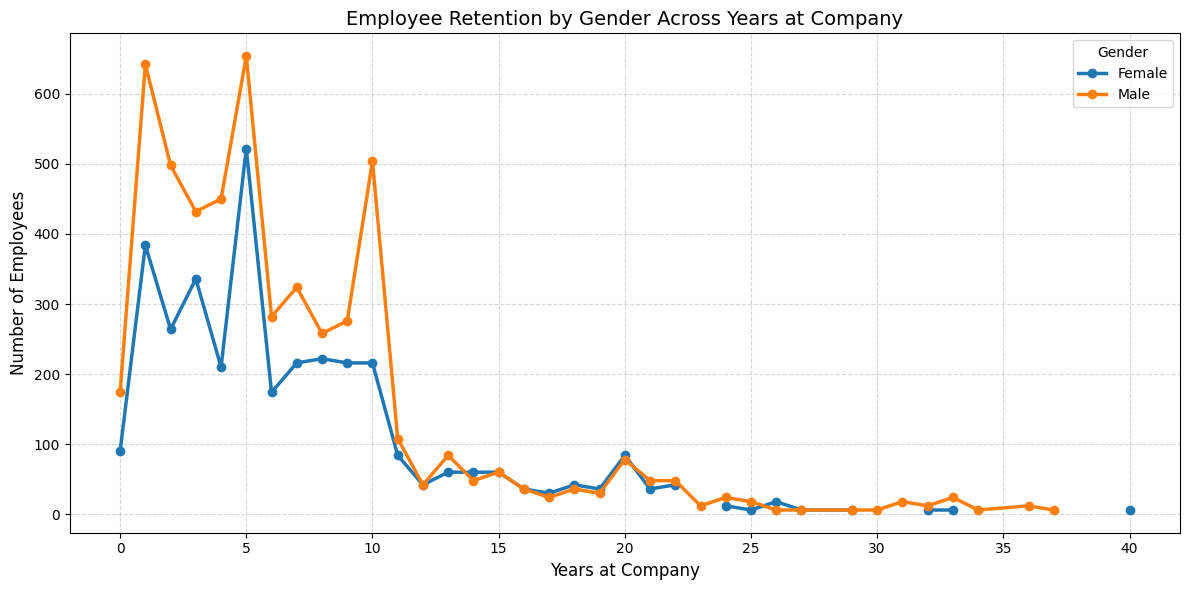

In [125]:
# Pivot data: years on X-axis, genders as separate lines
pivot_df = df.pivot_table(
    index="years_at_company",
    columns="gender",
    values="employee_id",   # Any column works, we just need a count
    aggfunc="count"
)

plt.figure(figsize=(12, 6))

# Plot each gender as a separate line
for gender in pivot_df.columns:
    plt.plot(
        pivot_df.index,
        pivot_df[gender],
        marker='o',
        linewidth=2.5,
        label=f"{gender}"
    )

plt.title("Employee Retention by Gender Across Years at Company", fontsize=14)
plt.xlabel("Years at Company", fontsize=12)
plt.ylabel("Number of Employees", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

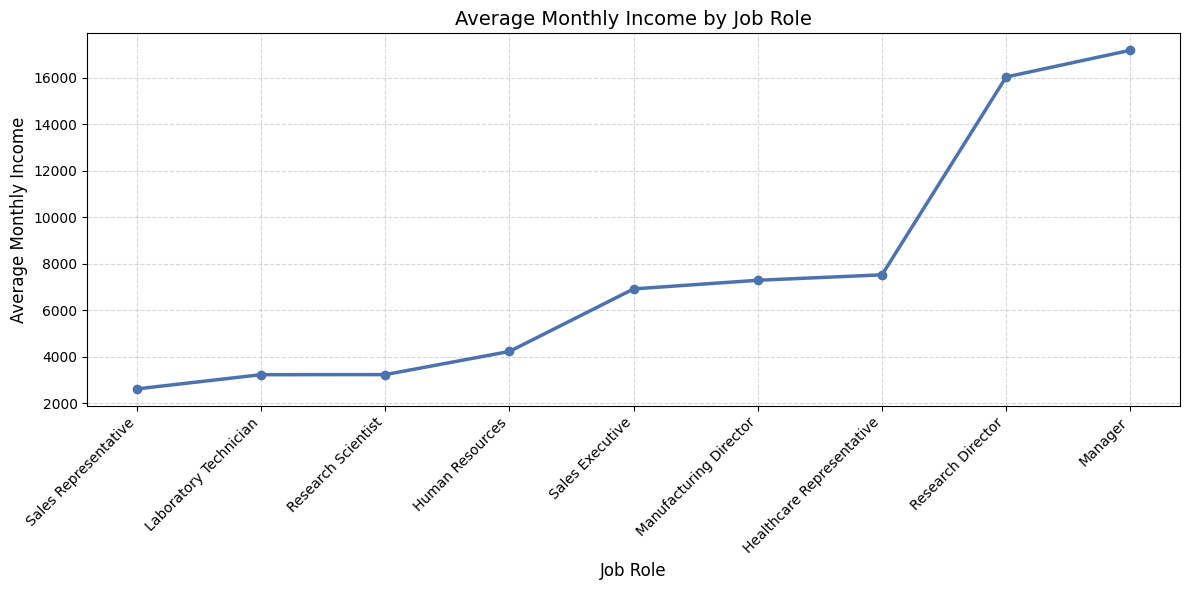

In [126]:
# Group by job role and compute average salary
jobrole_salary = df.groupby("job_role")["monthly_income"].mean().sort_values()

plt.figure(figsize=(12, 6))

plt.plot(
    jobrole_salary.index,
    jobrole_salary.values,
    marker='o',
    linewidth=2.5,
    color="#4C72B0"  # Soft blue
)

plt.title("Average Monthly Income by Job Role", fontsize=14)
plt.xlabel("Job Role", fontsize=12)
plt.ylabel("Average Monthly Income", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

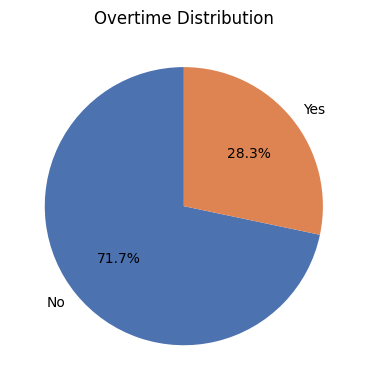

In [127]:
# Count overtime categories
overtime_count = df["overtime"].value_counts()

plt.figure(figsize=(5, 4))

plt.pie(
    overtime_count.values,
    labels=overtime_count.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#4C72B0", "#DD8452"]  # Blue & Orange theme
)

plt.title("Overtime Distribution")
plt.tight_layout()
plt.show()


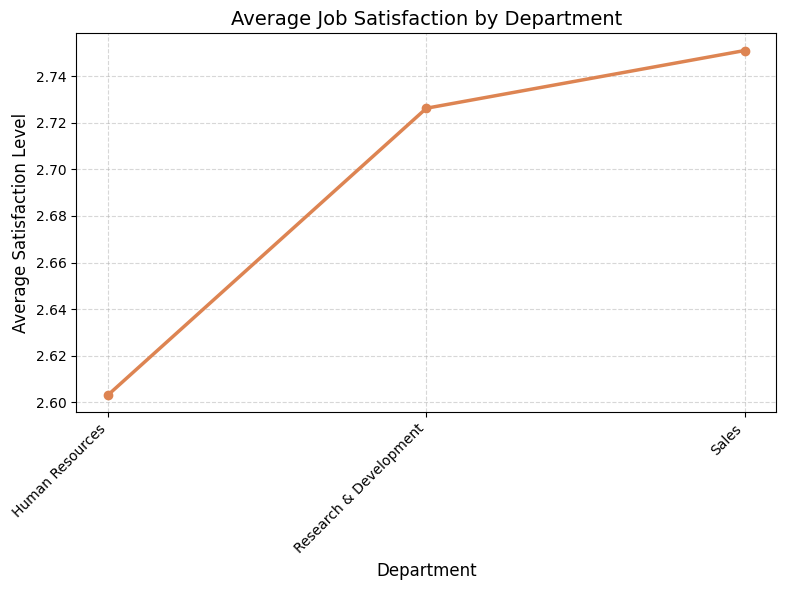

In [128]:
# Group by department and compute average job satisfaction
dept_satisfaction = df.groupby("department")["job_satisfaction"].mean().sort_values()

plt.figure(figsize=(8, 6))

plt.plot(
    dept_satisfaction.index,
    dept_satisfaction.values,
    marker='o',
    linewidth=2.5,
    color="#DD8452"  # Soft orange
)

plt.title("Average Job Satisfaction by Department", fontsize=14)
plt.xlabel("Department", fontsize=12)
plt.ylabel("Average Satisfaction Level", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


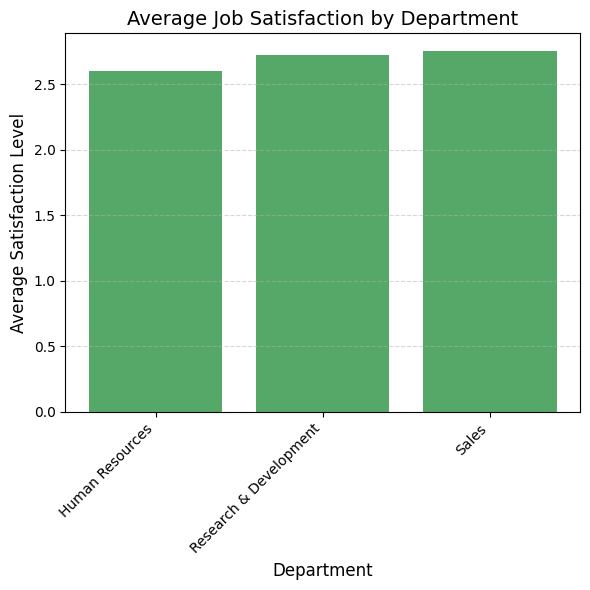

In [129]:
# Average job satisfaction for each department
dept_satisfaction = df.groupby("department")["job_satisfaction"].mean().sort_values()

plt.figure(figsize=(6, 6))

plt.bar(
    dept_satisfaction.index,
    dept_satisfaction.values,
    color="#55A868"  # Soft green
)

plt.title("Average Job Satisfaction by Department", fontsize=14)
plt.xlabel("Department", fontsize=12)
plt.ylabel("Average Satisfaction Level", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis="y", linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


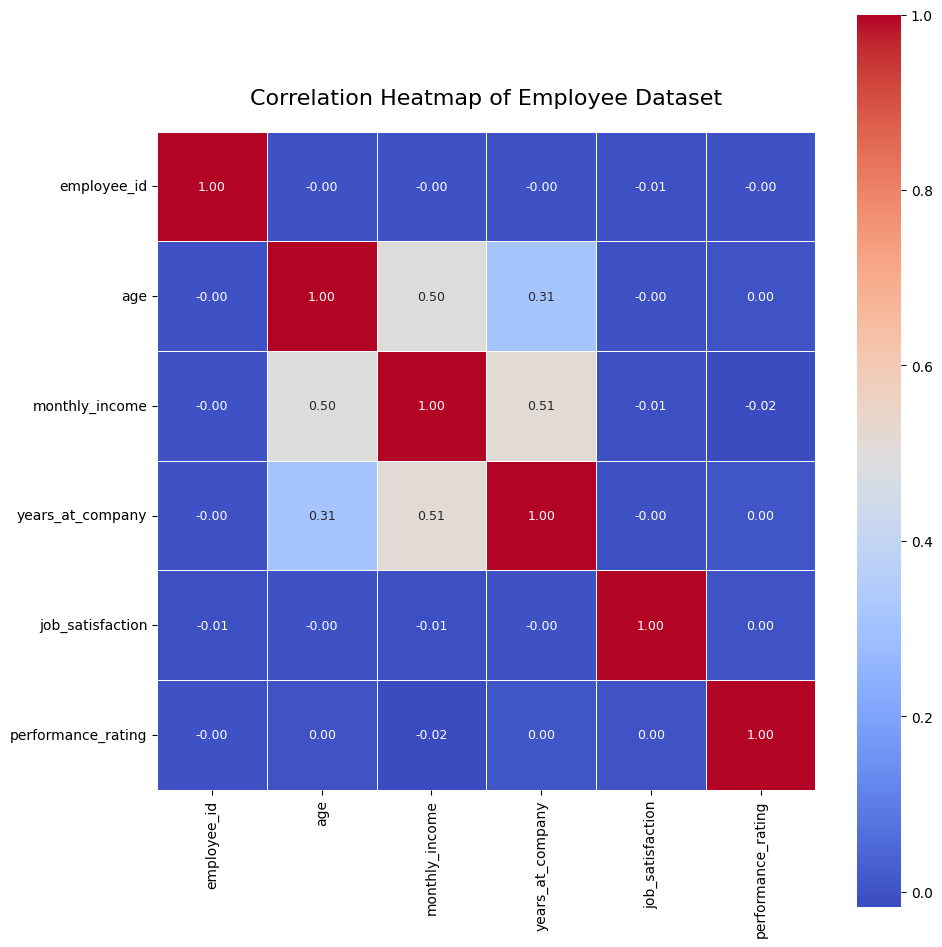

In [130]:
# we select numeric columns for correlation heatmap

numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10, 10))

sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    fmt=".2f",
    cbar=True,
    square=True,
    annot_kws={"size": 9}
)

plt.title("Correlation Heatmap of Employee Dataset", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [131]:
# Encode Yes/No Columns
yes_no_cols = ["overtime", "attrition"]

for col in yes_no_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})


In [132]:
#One-Hot Encode Categorical Columns
categorical_cols = ["gender", "department", "job_role"]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [134]:
df.head()

,employee_id,age,monthly_income,years_at_company,job_satisfaction,performance_rating,overtime,attrition,gender_Male,department_Research & Development,department_Sales,job_role_Human Resources,job_role_Laboratory Technician,job_role_Manager,job_role_Manufacturing Director,job_role_Research Director,job_role_Research Scientist,job_role_Sales Executive,job_role_Sales Representative
0,1,41,5993,6,4,3,1,1,False,False,True,False,False,False,False,False,False,True,False
1,2,49,5130,10,2,4,0,0,True,True,False,False,False,False,False,False,True,False,False
2,3,37,2090,0,3,3,1,1,True,True,False,False,True,False,False,False,False,False,False
3,4,33,2909,8,3,3,1,0,False,True,False,False,False,False,False,False,True,False,False
4,5,27,3468,2,2,3,0,0,True,True,False,False,True,False,False,False,False,False,False


In [133]:
# Saving the preprocessed dataset as a cleaned data set into processed data folder

df.to_csv("../data/processed/cleaned_employee_data.csv", index=False)
